# Ensemble Clustering Analysis

This notebook implements an ensemble clustering approach that combines results from multiple clustering algorithms (K-Means, DBSCAN, Hierarchical) to create a more robust consensus clustering.

**Approach:**
1. Load results from individual clustering methods
2. Create a co-association matrix based on pairwise cluster membership
3. Apply consensus clustering to derive final clusters
4. Evaluate ensemble quality using standard metrics
5. Generate recommendations based on consensus clusters

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load Individual Clustering Results
def load_clustering_results():
    """
    Load results from K-Means, DBSCAN, and Hierarchical clustering.
    """
    print("Loading clustering results from individual methods...")
    
    # Load clustered data from each method
    kmeans_df = pd.read_csv('../data/processed/clustered_suppliers.csv')
    dbscan_df = pd.read_csv('../data/processed/dbscan_clustered_suppliers.csv')
    hierarchical_df = pd.read_csv('../data/processed/hierarchical_clustered_suppliers.csv')
    
    print(f"K-Means clusters: {kmeans_df['cluster'].nunique()}")
    print(f"DBSCAN clusters: {dbscan_df['cluster'].nunique()} (including noise=-1)")
    print(f"Hierarchical clusters: {hierarchical_df['cluster'].nunique()}")
    
    # Ensure all dataframes have the same order
    assert len(kmeans_df) == len(dbscan_df) == len(hierarchical_df), "Dataframes have different lengths!"
    
    return kmeans_df, dbscan_df, hierarchical_df

kmeans_df, dbscan_df, hierarchical_df = load_clustering_results()
print(f"\nLoaded {len(kmeans_df)} data points from each clustering method.")

Loading clustering results from individual methods...
K-Means clusters: 5
DBSCAN clusters: 20 (including noise=-1)
Hierarchical clusters: 3

Loaded 2994 data points from each clustering method.


In [3]:
# Prepare Features and Create Co-Association Matrix
def create_coassociation_matrix(kmeans_labels, dbscan_labels, hierarchical_labels):
    """
    Create a co-association matrix where each element (i,j) represents
    the proportion of times points i and j are in the same cluster.
    """
    n_samples = len(kmeans_labels)
    coassoc_matrix = np.zeros((n_samples, n_samples))
    
    # For each clustering result
    for labels in [kmeans_labels, dbscan_labels, hierarchical_labels]:
        # Handle DBSCAN noise points (-1) by treating them as individual clusters
        labels_adjusted = labels.copy()
        noise_mask = labels_adjusted == -1
        if noise_mask.any():
            # Assign unique cluster IDs to noise points
            max_cluster = labels_adjusted.max()
            noise_indices = np.where(noise_mask)[0]
            labels_adjusted[noise_mask] = np.arange(max_cluster + 1, max_cluster + 1 + len(noise_indices))
        
        # Update co-association matrix
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels_adjusted[i] == labels_adjusted[j]:
                    coassoc_matrix[i, j] += 1
                    if i != j:
                        coassoc_matrix[j, i] += 1
    
    # Normalize by number of clustering methods
    coassoc_matrix /= 3
    
    return coassoc_matrix

print("Creating co-association matrix from individual clustering results...")
kmeans_labels = kmeans_df['cluster'].values
dbscan_labels = dbscan_df['cluster'].values
hierarchical_labels = hierarchical_df['cluster'].values

coassoc_matrix = create_coassociation_matrix(kmeans_labels, dbscan_labels, hierarchical_labels)
print(f"Co-association matrix shape: {coassoc_matrix.shape}")
print(f"Matrix value range: [{coassoc_matrix.min():.3f}, {coassoc_matrix.max():.3f}]")

Creating co-association matrix from individual clustering results...
Co-association matrix shape: (2994, 2994)
Matrix value range: [0.000, 1.000]


In [4]:
# Find Optimal Number of Consensus Clusters
def find_optimal_ensemble_clusters(coassoc_matrix, features, max_clusters=10):
    """
    Find optimal number of clusters for ensemble by applying clustering
    to the dissimilarity matrix (1 - co-association).
    """
    print("\nSearching for optimal number of consensus clusters...")
    print("Testing cluster counts from 3 to", max_clusters)
    
    # Convert co-association to dissimilarity
    dissimilarity = 1 - coassoc_matrix
    
    results = []
    MIN_CLUSTERS = 3  # Force minimum 3 clusters for better granularity
    
    for n_clusters in range(MIN_CLUSTERS, max_clusters + 1):
        # Apply hierarchical clustering on dissimilarity matrix
        clusterer = AgglomerativeClustering(
            n_clusters=n_clusters,
            metric='precomputed',
            linkage='average'
        )
        labels = clusterer.fit_predict(dissimilarity)
        
        # Evaluate using original features (not dissimilarity matrix)
        sil_score = silhouette_score(features, labels)
        db_score = davies_bouldin_score(features, labels)
        ch_score = calinski_harabasz_score(features, labels)
        
        results.append({
            'n_clusters': n_clusters,
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score
        })
        
        print(f"n_clusters={n_clusters}: sil={sil_score:.3f}, db={db_score:.3f}, ch={ch_score:.1f}")
    
    results_df = pd.DataFrame(results)
    
    # Select best based on silhouette score
    best_idx = results_df['silhouette'].idxmax()
    best_n_clusters = results_df.loc[best_idx, 'n_clusters']
    
    print(f"\nBest number of clusters: {best_n_clusters}")
    print(f"   Silhouette score: {results_df.loc[best_idx, 'silhouette']:.3f}")
    print(f"   Davies-Bouldin score: {results_df.loc[best_idx, 'davies_bouldin']:.3f}")
    print(f"   Calinski-Harabasz score: {results_df.loc[best_idx, 'calinski_harabasz']:.1f}")
    
    return int(best_n_clusters), results_df, dissimilarity

# Prepare features for evaluation
feature_columns = ['delivery_reliability', 'cost_efficiency', 'defect_rate', 
                   'quality_score', 'on_time_delivery_rate', 'response_time_hours', 
                   'customer_satisfaction']
features = kmeans_df[feature_columns].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

optimal_n_clusters, search_results, dissimilarity_matrix = find_optimal_ensemble_clusters(
    coassoc_matrix, features_scaled
)


Searching for optimal number of consensus clusters...
Testing cluster counts from 3 to 10
n_clusters=3: sil=0.276, db=1.137, ch=560.4
n_clusters=4: sil=0.176, db=1.063, ch=375.7
n_clusters=5: sil=0.149, db=1.311, ch=283.4
n_clusters=6: sil=0.131, db=1.185, ch=227.4
n_clusters=7: sil=0.159, db=1.291, ch=309.5
n_clusters=8: sil=0.182, db=1.335, ch=404.4
n_clusters=9: sil=0.202, db=1.397, ch=482.6
n_clusters=10: sil=0.175, db=1.482, ch=453.1

Best number of clusters: 3
   Silhouette score: 0.276
   Davies-Bouldin score: 1.137
   Calinski-Harabasz score: 560.4


In [5]:
# Apply Ensemble Clustering
def apply_ensemble_clustering(dissimilarity_matrix, n_clusters):
    """
    Apply consensus clustering using the dissimilarity matrix.
    """
    print(f"\nApplying ensemble clustering with {n_clusters} clusters...")
    
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    
    labels = clusterer.fit_predict(dissimilarity_matrix)
    
    # Get cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\nEnsemble Cluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"   • Cluster_{cluster_id}: {count} ({percentage:.1f}%)")
    
    return labels

ensemble_labels = apply_ensemble_clustering(dissimilarity_matrix, optimal_n_clusters)

# Add ensemble labels to dataframe
ensemble_df = kmeans_df.copy()
ensemble_df['cluster'] = ensemble_labels

print(f"\nEnsemble clustering complete with {len(ensemble_df)} data points.")


Applying ensemble clustering with 3 clusters...

Ensemble Cluster Distribution:
   • Cluster_0: 130 (4.3%)
   • Cluster_1: 2531 (84.5%)
   • Cluster_2: 333 (11.1%)

Ensemble clustering complete with 2994 data points.


In [6]:
# Analyze Cluster Characteristics
def analyze_cluster_characteristics(df, feature_columns):
    """
    Analyze and summarize characteristics of each ensemble cluster.
    """
    print("\nAnalyzing ensemble cluster characteristics...\n")
    
    cluster_stats = df.groupby('cluster')[feature_columns].agg(['mean', 'std'])
    
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id} - {len(cluster_data)} suppliers ({len(cluster_data)/len(df)*100:.1f}%)")
        print(f"{'='*60}")
        
        for feature in feature_columns:
            mean_val = cluster_stats.loc[cluster_id, (feature, 'mean')]
            std_val = cluster_stats.loc[cluster_id, (feature, 'std')]
            print(f"{feature:30s}: {mean_val:6.3f} ± {std_val:5.3f}")
    
    return cluster_stats

cluster_stats = analyze_cluster_characteristics(ensemble_df, feature_columns)


Analyzing ensemble cluster characteristics...


CLUSTER 0 - 130 suppliers (4.3%)
delivery_reliability          : 40.837 ± 4.636
cost_efficiency               : 36.860 ± 6.391
defect_rate                   :  4.680 ± 1.338
quality_score                 : 54.264 ± 3.630
on_time_delivery_rate         : 40.519 ± 3.812
response_time_hours           : 20.134 ± 2.605
customer_satisfaction         :  4.666 ± 0.623

CLUSTER 1 - 2531 suppliers (84.5%)
delivery_reliability          : 65.727 ± 10.698
cost_efficiency               : 66.541 ± 14.727
defect_rate                   :  1.762 ± 0.885
quality_score                 : 69.348 ± 17.693
on_time_delivery_rate         : 65.772 ± 10.947
response_time_hours           : 20.864 ± 5.258
customer_satisfaction         :  7.054 ± 0.861

CLUSTER 2 - 333 suppliers (11.1%)
delivery_reliability          : 84.478 ± 8.871
cost_efficiency               : 52.192 ± 15.073
defect_rate                   :  3.819 ± 1.879
quality_score                 : 46.325 ± 4.


Generating ensemble clustering visualizations...
Visualization saved to: ../data/results/ensemble_clustering_visualization.png


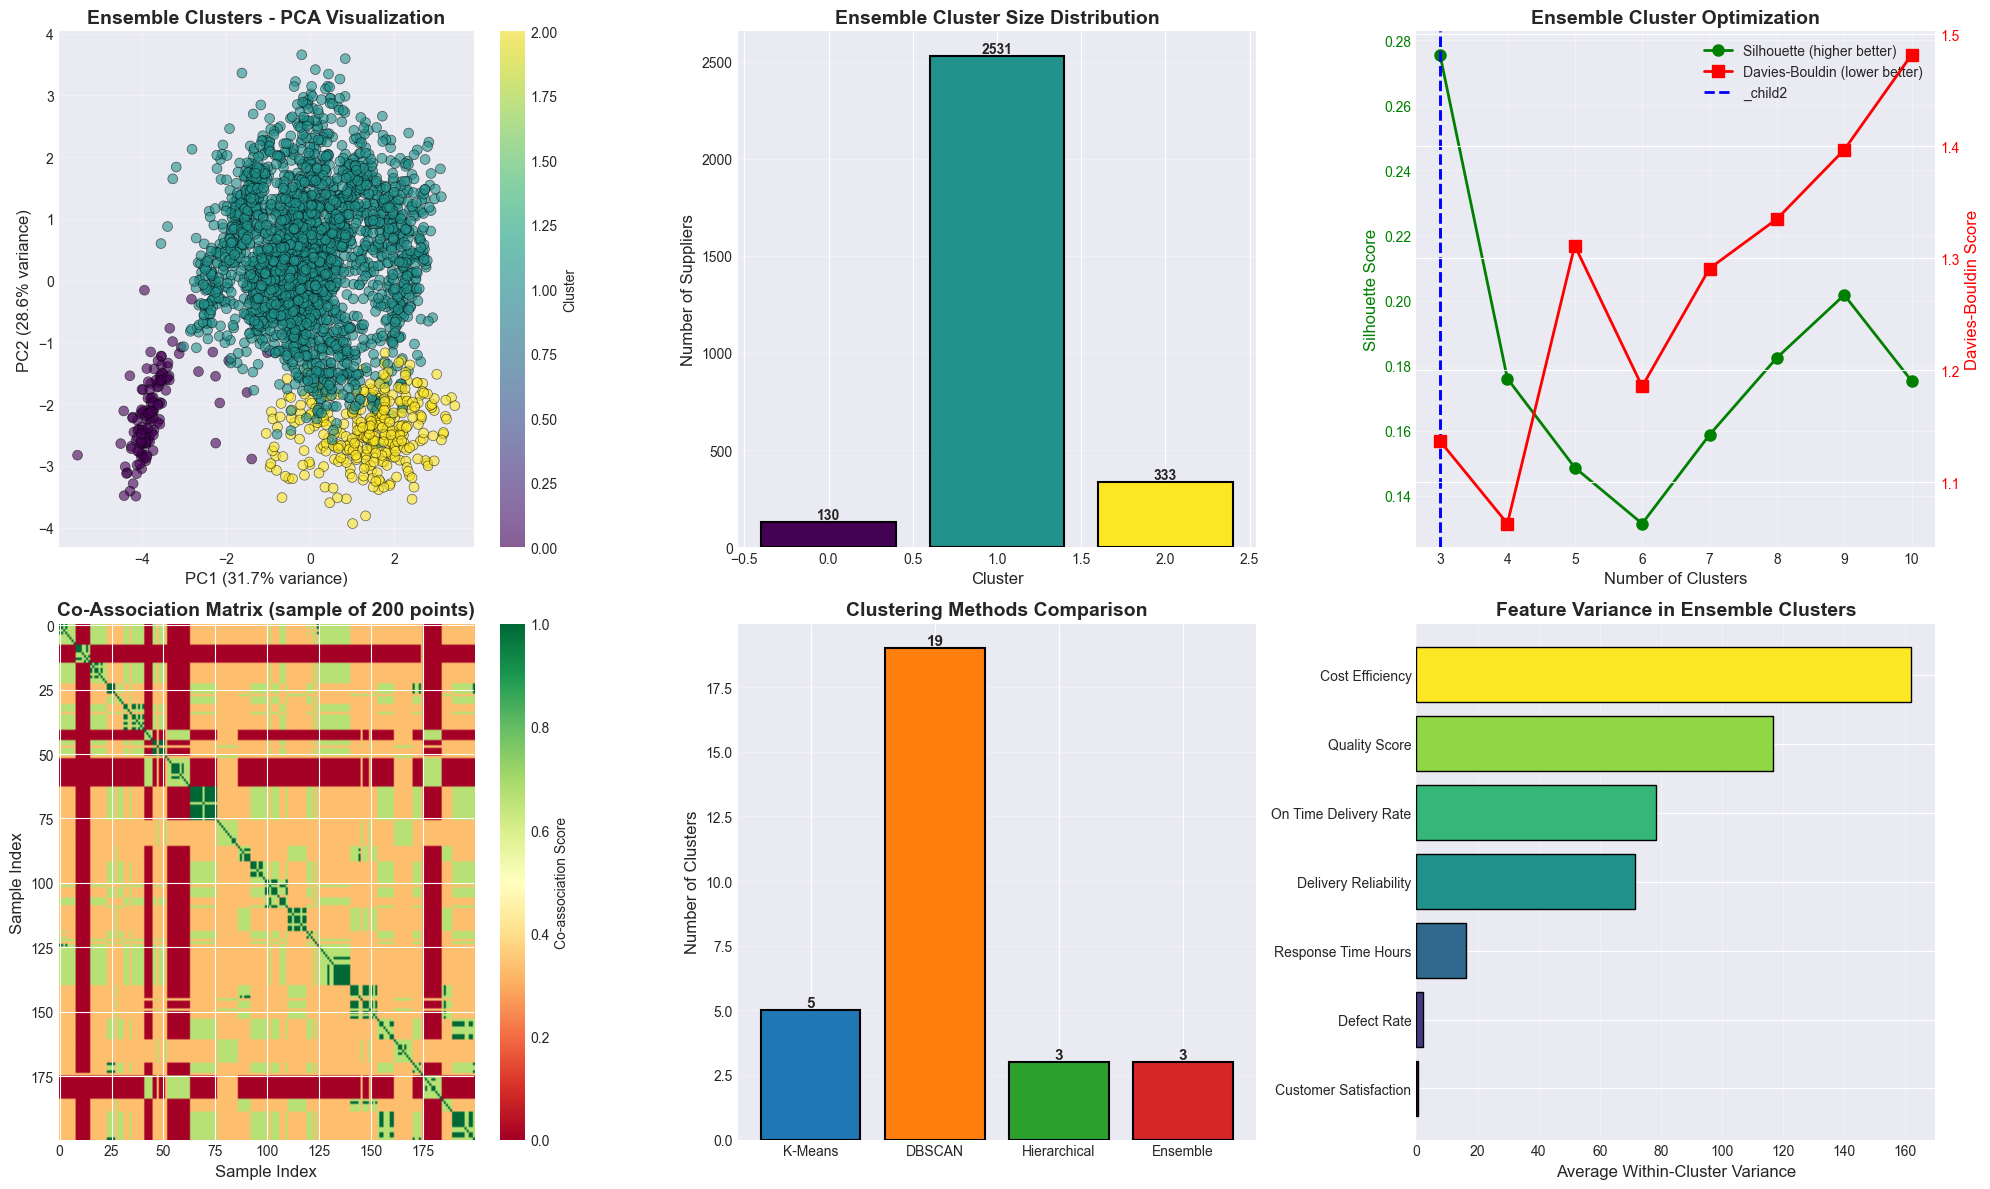

In [7]:
# Visualize Ensemble Clustering Results
def visualize_ensemble_results(df, features_scaled, coassoc_matrix, search_results):
    """
    Create comprehensive visualizations of ensemble clustering results.
    """
    print("\nGenerating ensemble clustering visualizations...")
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. PCA Visualization of Ensemble Clusters
    ax1 = plt.subplot(2, 3, 1)
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features_scaled)
    
    scatter = ax1.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=df['cluster'], cmap='viridis', 
                         s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    ax1.set_title('Ensemble Clusters - PCA Visualization', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    ax1.grid(True, alpha=0.3)
    
    # 2. Cluster Size Distribution
    ax2 = plt.subplot(2, 3, 2)
    cluster_counts = df['cluster'].value_counts().sort_index()
    bars = ax2.bar(cluster_counts.index, cluster_counts.values, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_counts))),
                   edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Cluster', fontsize=12)
    ax2.set_ylabel('Number of Suppliers', fontsize=12)
    ax2.set_title('Ensemble Cluster Size Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 3. Optimization Metrics
    ax3 = plt.subplot(2, 3, 3)
    ax3_twin = ax3.twinx()
    
    line1 = ax3.plot(search_results['n_clusters'], search_results['silhouette'], 
                     'o-', linewidth=2, markersize=8, color='green', label='Silhouette (higher better)')
    line2 = ax3_twin.plot(search_results['n_clusters'], search_results['davies_bouldin'], 
                          's-', linewidth=2, markersize=8, color='red', label='Davies-Bouldin (lower better)')
    
    ax3.set_xlabel('Number of Clusters', fontsize=12)
    ax3.set_ylabel('Silhouette Score', fontsize=12, color='green')
    ax3_twin.set_ylabel('Davies-Bouldin Score', fontsize=12, color='red')
    ax3.set_title('Ensemble Cluster Optimization', fontsize=14, fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    ax3.grid(True, alpha=0.3)
    
    # Mark optimal point
    best_idx = search_results['silhouette'].idxmax()
    best_n = search_results.loc[best_idx, 'n_clusters']
    ax3.axvline(x=best_n, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal: {int(best_n)}')
    
    lines = line1 + line2 + [ax3.axvline(x=best_n, color='blue', linestyle='--', linewidth=2)]
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='best', fontsize=10)
    
    # 4. Co-Association Matrix Heatmap (sample)
    ax4 = plt.subplot(2, 3, 4)
    sample_size = min(200, len(coassoc_matrix))
    sample_indices = np.random.choice(len(coassoc_matrix), sample_size, replace=False)
    sample_indices.sort()
    coassoc_sample = coassoc_matrix[np.ix_(sample_indices, sample_indices)]
    
    im = ax4.imshow(coassoc_sample, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_title(f'Co-Association Matrix (sample of {sample_size} points)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Sample Index', fontsize=12)
    ax4.set_ylabel('Sample Index', fontsize=12)
    plt.colorbar(im, ax=ax4, label='Co-association Score')
    
    # 5. Consensus vs Individual Methods
    ax5 = plt.subplot(2, 3, 5)
    method_comparison = pd.DataFrame({
        'K-Means': [kmeans_df['cluster'].nunique()],
        'DBSCAN': [dbscan_df[dbscan_df['cluster'] != -1]['cluster'].nunique()],
        'Hierarchical': [hierarchical_df['cluster'].nunique()],
        'Ensemble': [df['cluster'].nunique()]
    })
    
    bars = ax5.bar(method_comparison.columns, method_comparison.iloc[0], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                   edgecolor='black', linewidth=1.5)
    ax5.set_ylabel('Number of Clusters', fontsize=12)
    ax5.set_title('Clustering Methods Comparison', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 6. Feature Importance by Cluster Variance
    ax6 = plt.subplot(2, 3, 6)
    feature_variance = df.groupby('cluster')[feature_columns].var().mean()
    feature_variance_sorted = feature_variance.sort_values(ascending=True)
    
    bars = ax6.barh(range(len(feature_variance_sorted)), feature_variance_sorted.values,
                    color=plt.cm.viridis(np.linspace(0, 1, len(feature_variance_sorted))),
                    edgecolor='black', linewidth=1)
    ax6.set_yticks(range(len(feature_variance_sorted)))
    ax6.set_yticklabels([label.replace('_', ' ').title() for label in feature_variance_sorted.index], fontsize=10)
    ax6.set_xlabel('Average Within-Cluster Variance', fontsize=12)
    ax6.set_title('Feature Variance in Ensemble Clusters', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('../data/results/ensemble_clustering_visualization.png', dpi=300, bbox_inches='tight')
    print("Visualization saved to: ../data/results/ensemble_clustering_visualization.png")
    plt.show()

visualize_ensemble_results(ensemble_df, features_scaled, coassoc_matrix, search_results)

In [8]:
# Generate Cluster Recommendations
def generate_cluster_recommendations(df, cluster_stats, feature_columns):
    """
    Generate actionable recommendations for each ensemble cluster.
    """
    print("\nGenerating recommendations for each ensemble cluster...\n")
    
    recommendations = []
    
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        
        # Calculate feature means for this cluster
        means = {feature: cluster_stats.loc[cluster_id, (feature, 'mean')] 
                for feature in feature_columns}
        
        # Identify strengths (top 2 features)
        sorted_features = sorted(means.items(), key=lambda x: x[1], reverse=True)
        strengths = [f.replace('_', ' ').title() for f, _ in sorted_features[:2]]
        
        # Identify improvement areas (bottom 2 features, excluding defect_rate and response_time)
        improvement_candidates = [(f, v) for f, v in sorted_features 
                                 if f not in ['defect_rate', 'response_time_hours']]
        improvements = [f.replace('_', ' ').title() for f, _ in improvement_candidates[-2:]]
        
        # Determine cluster profile
        avg_quality = means['quality_score']
        avg_reliability = means['delivery_reliability']
        avg_cost = means['cost_efficiency']
        
        if avg_quality >= 0.8 and avg_reliability >= 0.85:
            profile = "Premium Suppliers"
            strategy = "Maintain partnership and leverage for critical projects"
        elif avg_quality >= 0.7 and avg_cost >= 0.75:
            profile = "Balanced Performers"
            strategy = "Focus on consistency and incremental improvements"
        elif avg_cost >= 0.8:
            profile = "Cost-Effective Suppliers"
            strategy = "Invest in quality improvement programs"
        else:
            profile = "Developing Suppliers"
            strategy = "Provide support and consider alternative sourcing"
        
        recommendation = {
            'Cluster': cluster_id,
            'Profile': profile,
            'Size': cluster_size,
            'Percentage': f"{cluster_size/len(df)*100:.1f}%",
            'Key Strengths': ', '.join(strengths),
            'Improvement Areas': ', '.join(improvements),
            'Recommended Strategy': strategy
        }
        
        recommendations.append(recommendation)
        
        print(f"\nCluster {cluster_id}: {profile}")
        print(f"  Size: {cluster_size} suppliers ({cluster_size/len(df)*100:.1f}%)")
        print(f"  Strengths: {', '.join(strengths)}")
        print(f"  Improvements: {', '.join(improvements)}")
        print(f"  Strategy: {strategy}")
    
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df

recommendations_df = generate_cluster_recommendations(ensemble_df, cluster_stats, feature_columns)
print("\n" + "="*80)
print("Ensemble clustering recommendations generated successfully!")
print("="*80)


Generating recommendations for each ensemble cluster...


Cluster 0: Premium Suppliers
  Size: 130 suppliers (4.3%)
  Strengths: Quality Score, Delivery Reliability
  Improvements: Cost Efficiency, Customer Satisfaction
  Strategy: Maintain partnership and leverage for critical projects

Cluster 1: Premium Suppliers
  Size: 2531 suppliers (84.5%)
  Strengths: Quality Score, Cost Efficiency
  Improvements: Delivery Reliability, Customer Satisfaction
  Strategy: Maintain partnership and leverage for critical projects

Cluster 2: Premium Suppliers
  Size: 333 suppliers (11.1%)
  Strengths: Delivery Reliability, On Time Delivery Rate
  Improvements: Quality Score, Customer Satisfaction
  Strategy: Maintain partnership and leverage for critical projects

Ensemble clustering recommendations generated successfully!


In [9]:
# Save Ensemble Clustering Results
def save_ensemble_results(df, recommendations_df, cluster_stats, search_results):
    """
    Save all ensemble clustering results to files.
    """
    print("\nSaving ensemble clustering results...\n")
    
    # 1. Save clustered data
    csv_path = '../data/processed/ensemble_clustered_suppliers.csv'
    df.to_csv(csv_path, index=False)
    print(f"✓ Clustered data saved to: {csv_path}")
    
    json_path = '../data/processed/ensemble_clustered_suppliers.json'
    df.to_json(json_path, orient='records', indent=2)
    print(f"✓ Clustered data saved to: {json_path}")
    
    # 2. Save cluster summary statistics
    summary_path = '../data/results/ensemble_cluster_summary.csv'
    cluster_stats.to_csv(summary_path)
    print(f"✓ Cluster summary saved to: {summary_path}")
    
    # 3. Save recommendations
    recommendations_path = '../data/results/ensemble_cluster_recommendations.csv'
    recommendations_df.to_csv(recommendations_path, index=False)
    print(f"✓ Recommendations saved to: {recommendations_path}")
    
    # 4. Save optimization results
    optimization_path = '../data/results/ensemble_parameter_search.csv'
    search_results.to_csv(optimization_path, index=False)
    print(f"✓ Parameter search results saved to: {optimization_path}")
    
    # 5. Generate summary report
    report_path = '../data/results/ensemble_clustering_summary_report.txt'
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("ENSEMBLE CLUSTERING ANALYSIS SUMMARY REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write("METHODOLOGY\n")
        f.write("-" * 40 + "\n")
        f.write("Approach: Consensus clustering using co-association matrix\n")
        f.write("Input Methods: K-Means, DBSCAN, Hierarchical\n")
        f.write("Consensus Method: Hierarchical clustering on dissimilarity matrix\n")
        f.write(f"Optimal Clusters: {optimal_n_clusters}\n\n")
        
        f.write("DATASET INFORMATION\n")
        f.write("-" * 40 + "\n")
        f.write(f"Total data points: {len(df)}\n")
        f.write(f"Number of features: {len(feature_columns)}\n")
        f.write(f"Features: {', '.join(feature_columns)}\n\n")
        
        f.write("ENSEMBLE CLUSTERING RESULTS\n")
        f.write("-" * 40 + "\n")
        best_idx = search_results['silhouette'].idxmax()
        f.write(f"Number of clusters: {optimal_n_clusters}\n")
        f.write(f"Silhouette score: {search_results.loc[best_idx, 'silhouette']:.4f}\n")
        f.write(f"Davies-Bouldin score: {search_results.loc[best_idx, 'davies_bouldin']:.4f}\n")
        f.write(f"Calinski-Harabasz score: {search_results.loc[best_idx, 'calinski_harabasz']:.2f}\n\n")
        
        f.write("CLUSTER DISTRIBUTION\n")
        f.write("-" * 40 + "\n")
        for cluster_id in sorted(df['cluster'].unique()):
            count = len(df[df['cluster'] == cluster_id])
            percentage = count / len(df) * 100
            f.write(f"Cluster {cluster_id}: {count} suppliers ({percentage:.1f}%)\n")
        
        f.write("\n" + "="*80 + "\n")
        f.write("CLUSTER PROFILES AND RECOMMENDATIONS\n")
        f.write("="*80 + "\n\n")
        
        for _, rec in recommendations_df.iterrows():
            f.write(f"\nCLUSTER {rec['Cluster']}: {rec['Profile']}\n")
            f.write("-" * 40 + "\n")
            f.write(f"Size: {rec['Size']} suppliers ({rec['Percentage']})\n")
            f.write(f"Key Strengths: {rec['Key Strengths']}\n")
            f.write(f"Improvement Areas: {rec['Improvement Areas']}\n")
            f.write(f"Strategy: {rec['Recommended Strategy']}\n")
    
    print(f"✓ Summary report saved to: {report_path}")
    print("\n" + "="*80)
    print("All ensemble clustering results saved successfully!")
    print("="*80)

save_ensemble_results(ensemble_df, recommendations_df, cluster_stats, search_results)


Saving ensemble clustering results...

✓ Clustered data saved to: ../data/processed/ensemble_clustered_suppliers.csv
✓ Clustered data saved to: ../data/processed/ensemble_clustered_suppliers.json
✓ Cluster summary saved to: ../data/results/ensemble_cluster_summary.csv
✓ Recommendations saved to: ../data/results/ensemble_cluster_recommendations.csv
✓ Parameter search results saved to: ../data/results/ensemble_parameter_search.csv
✓ Summary report saved to: ../data/results/ensemble_clustering_summary_report.txt

All ensemble clustering results saved successfully!
